# Projet de système de recommandation
Module Data Mining - CPE Lyon 2023

*Auteurs : Hugo MARTA et Léo GONNET (4ETI)*

---


In [19]:
# Importation des bibliothèques
import os
import numpy as np
import math
import sys
import pandas as pd
import json
import requests # requêtes http
import urllib.request # téléchargement d'images
import shutil # recursive rem
from time import sleep
from PIL import Image
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.cluster import KMeans
from uuid import uuid4 #générateur d'identifiant unique
import random as rd
from SPARQLWrapper import SPARQLWrapper, JSON

## **1.** Collecte de données

On va récupérer les images sur Wikimedia Commons à l'aide de son API.
On utilise la bibliothèque requests pour faire les requêtes HTTP.

⚠️ À chaque execution on écrase le dossier d'image !

In [22]:
# Nombre d'images à télécharger maximum
NB_IMG_MAX = 100

# Mots-clés des thèmes à rechercher
KEYWORDS = ["Horse", "Car"]

# Chemins
images_path = './images/'
bdd_path = './bdd.csv'

# Remise à zéro des données (Suppression de toutes les images déjà téléchargées et de la BDD)
if os.path.exists(images_path):
    shutil.rmtree(images_path)
os.makedirs(images_path)
if os.path.isfile(bdd_path):
    os.remove(bdd_path)

#On initialise le dataframe de la base de données
bdd_df = pd.DataFrame(columns=['ID', 'sha1', 'annee', 'largeur', 'hauteur', 'url'])

def get_results(endpoint_url, query):
    # Fonction pour exécuter la requête SPARQL
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# Endpoint SPARQL de Wikidata
endpoint_url = "https://query.wikidata.org/sparql"

# Requête SPARQL pour récupérer les images des chevaux depuis Wikidata
query= """
SELECT DISTINCT ?horse ?horseLabel ?image WHERE {
    ?horse wdt:P31 wd:Q726.
    ?horse wdt:P18 ?image. 
    SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 100
"""

# Récupération des résultats de la requête SPARQL
results = get_results(endpoint_url, query)

# Extraction des données et stockage dans un DataFrame
array = []
for result in results["results"]["bindings"]:
    array.append((result["horseLabel"]["value"], result["image"]["value"]))

dataframe = pd.DataFrame(array, columns=["car", "image"])
dataframe = dataframe.astype(
    dtype={"car": "<U200", "image": "<U200"}
)

# Initialisation du DataFrame vide
bdd_df = pd.DataFrame(columns=['ID', 'sha1', 'annee', 'largeur', 'hauteur', 'url'])

# Téléchargement des images
img_dl = 0
for index, row in dataframe.iterrows():
    if img_dl >= NB_IMG_MAX:
        break
    url = row['image']
    filename = os.path.basename(url)
    filepath = os.path.join(images_path, filename)
    urllib.request.urlretrieve(url, filepath)
    new_row = pd.DataFrame({'ID': [img_dl], 'sha1': [filename], 'annee': [dt.datetime.now().year], 'largeur': [0], 'hauteur': [0], 'url': [url]})
    bdd_df = pd.concat([bdd_df, new_row], ignore_index=True)
    img_dl += 1

# Ecriture de la base de données dans un fichier 
bdd_df.to_csv(bdd_path, index=False)

print(f"{img_dl} images ont été téléchargées.")

100 images ont été téléchargées.


## **2.** Étiquetage et annotation

Nous avons déjà pu récupérer une partie des étiquettes pour nos images grâce à la base de données de wikimedia.

Nous ajoutons la couleur dominante de chaque image grâce à notre l'implémentation d'un algorithme de K-Means.

In [26]:
def recup_couleur_1(image_path):
  imgfile = Image.open(image_path)
  imgfile = imgfile.convert('RGB')  # Convertir en mode RVB pour éviter les problèmes de transparence
  imgfile = imgfile.resize((100, 100))  # Ajuster la taille de l'image
  numarray = np.array(imgfile)  # Obtenir les valeurs des pixels sous forme de tableau
  clusters = KMeans(n_clusters=4, n_init='auto')
  clusters.fit(numarray.reshape(-1, 3))  # Ajuster la forme de l'array à 2D
  # Le reste du code reste inchangé
  
  # Trier les centres par fréquence décroissante
  counts = np.unique(clusters.labels_, return_counts=True)[1]
  sort_index = np.argsort(counts)[::-1]
  sorted_centers = clusters.cluster_centers_[sort_index]

  # Récupérer la couleur principale (premier centre trié)
  main_color = sorted_centers[0]
  return main_color.tolist()

bdd_df['couleur']=''

for index, row in bdd_df.iterrows():
    print(f'\rProgression : {index+1}/{len(bdd_df)}', end='')
    # Construire le chemin de l'image
    path = 'images/' + row['sha1'] + '.jpg'
    path = path.replace('.jpg.jpg', '.jpg')
    
    # Vérifier si le fichier existe avant de tenter de l'ouvrir
    if os.path.exists(path):
        coul = recup_couleur_1(path)
        bdd_df.at[index,'couleur'] = coul
    else:
        print(f'Fichier non trouvé : {path}')

print('\n')


bdd_df.to_csv(bdd_path, index=False)

Progression : 6/100Fichier non trouvé : images/Eri-Aaroni.JPG.jpg
Progression : 24/100Fichier non trouvé : images/Indigenous.JPG.jpg
Progression : 49/100Fichier non trouvé : images/Stsimon01.JPG.jpg
Progression : 58/100Fichier non trouvé : images/1999-4-11-UmenoFiber.JPG.jpg
Progression : 70/100Fichier non trouvé : images/Kizuna%20IMG%207021-2%2020140406.JPG.jpg
Progression : 72/100Fichier non trouvé : images/%E7%9A%90%E6%9C%88%E8%B3%9E%20%E3%82%B3%E3%83%87%E3%82%A3%E3%83%BC%E3%83%8E.JPG.jpg
Progression : 73/100Fichier non trouvé : images/Wind%20in%20Her%20Hair%2020140803.JPG.jpg
Progression : 75/100Fichier non trouvé : images/Airdublin.JPG.jpg
Progression : 79/100Fichier non trouvé : images/Eishin%20Washington%202%2019960616.JPG.jpg
Progression : 84/100Fichier non trouvé : images/King%20Halo%202%2019971005.JPG.jpg
Progression : 93/100Fichier non trouvé : images/Ayusan-20130407.JPG.jpg
Progression : 95/100Fichier non trouvé : images/%E3%82%A8%E3%82%A2%E3%83%A1%E3%82%B5%E3%82%A4%E3%82%A

## **3.** Analyses de données


In [31]:
class Utilisateur():
  def __init__(self, name=None ):
    self.id = uuid4()
    self.name = name
    self.path = {
        'profil' : "./profils.json",
        'bdd' : "./bdd.csv"
    }
    self.likes = set()
  
  def like(self, image):
    self.likes.add(image)
  
  def dislike(self, image):
    self.dislikes.add(image)
  
  def enregistrer(self):
    #sauvergade un profil 
    ...
      
  def charger(self, path):
    #charge un profil précédemment enregistré
    ...
      
  def recommander(self):
    taille_int = {
      'petite' : 0,
      'moyenne' : 1,
      'grande' : 2
    }
    # Recommandation d'une image en fonction du profil utilisateur

    id_images_aimees = list(self.likes)

    # Charger les informations sur les photos dans la base de données
    bdd_df = pd.read_csv(self.path['bdd'])

    # Calculer la distance euclidienne entre les photos aimées et les photos de la base de données
    distances = []
    for ind in range(len(bdd_df)):
      row = bdd_df.loc[ind]
      couleur_image_float = eval(bdd_df.loc[ind, 'couleur'])
      couleur_image = np.array(couleur_image_float)
      annee_image = row['annee']
      taille_image = taille_int[row['taille']]
      distance = 0
      for id in id_images_aimees:
        couleur_image_aimee_float = eval(bdd_df.loc[id, 'couleur'])
        couleur_image_aimee = np.array(couleur_image_aimee_float)
        annee_image_aimee = bdd_df.loc[id,'annee']
        taille_image_aimee = taille_int[bdd_df.loc[id,'taille']]
        distance += np.linalg.norm(couleur_image - couleur_image_aimee)/100
        distance += abs(annee_image - annee_image_aimee)/2
        distance += abs(taille_image - taille_image_aimee)
      distances.append((row['ID'], distance))

    # Trier les photos par ordre de similarité
    distances.sort(key=lambda x: x[1])

    return distances[rd.randint(0, 4)][0]


## **4.** Visualisation des données

Text(0, 0.5, 'Nombre')

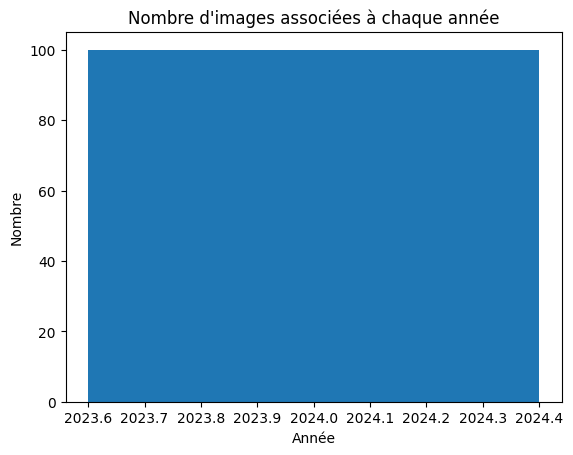

In [28]:
#Liste contenant l'année de chaque image
annees=[]
#Lecture du fichier csv dans un dataframe
bdd_df=pd.read_csv('bdd.csv')
for ind,row in bdd_df.iterrows():
  annees.append(row["annee"])

#On compte le nombre de répétitions de chaque année
nbr_images_annee = [(i,annees.count(i)) for i in range(min(annees),max(annees)+1)]
##print(f'Nombre d\'images disponibles par année :{nbr_images_annee}')
#On affiche les données sous forme de graphique
plt.bar([x[0] for x in nbr_images_annee],[x[1] for x in nbr_images_annee])
plt.title("Nombre d'images associées à chaque année")
plt.xlabel("Année")
plt.ylabel("Nombre")

In [29]:
#Initialisation des compteurs d'images
nbr_petites=0
nbr_moyennes=0
nbr_grandes=0
#Lecture du fichier csv dans un dataframe
bdd_df=pd.read_csv('bdd.csv')
#Ajout d'une nouvelle colonne vide 'taille'
bdd_df['taille']=''
#On parcourt les images pour compter les différentes tailles et les ajouter à la BDD
for ind,row in bdd_df.iterrows():
  taille_acc=''
  taille=(row["largeur"],row["hauteur"])
  if taille[0]<1280 or taille[1]<720:
    nbr_petites+=1
    taille_acc='petite'
  elif taille[0]<2560 or taille[1]<1440:
    nbr_moyennes+=1
    taille_acc='moyenne'
  else:
    nbr_grandes+=1
    taille_acc='grande'
  bdd_df.at[ind,'taille']=taille_acc
#On copie la BDD actualisée dans le fichier CSV
bdd_df.to_csv('bdd.csv', index=False)
#On affiche le nombre d'images par taille
affichage_tailles = {'Taille': ['Petites', 'Moyennes', 'Grandes'],'Nombre': [nbr_petites, nbr_moyennes, nbr_grandes]}
print(pd.DataFrame(affichage_tailles).to_string(index=False))

  Taille  Nombre
 Petites     100
Moyennes       0
 Grandes       0


## **5.** Visualisation des données

In [30]:
user1 = Utilisateur('Toto')
user1.likes.update([4,65,34,21])
id_reco = user1.recommander()
print(id_reco)

path = f"images/{bdd_df.loc[id_reco, 'sha1']}.jpg"
image = img.imread(path)
plt.imshow(image)
plt.show()

TypeError: eval() arg 1 must be a string, bytes or code object